**<font size=6>ACA Project: REBALANCE AI</font><br>**
**<font size=4>RL Stock Trading using DQN**</font><br><br>
**Mentors** : Naman Mohan Singh, Ashish Kr. Jha, Karan Kumar<br>
**Mentee** : Sarthak Sehgal

In [1]:
# Install required packages if running in a new environment
!pip install --quiet yfinance gym==0.25.2 torch torchvision torchaudio pandas numpy matplotlib

# %% Imports
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00


/tmp/ipython-input-20-2951419495.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-20-2951419495.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=['rolling_std'], inplace=True)


Episode 1/500, Total Reward: 493.56
Episode 2/500, Total Reward: 181.10
Episode 3/500, Total Reward: 107.37
Episode 4/500, Total Reward: 1192.65
Episode 5/500, Total Reward: 523.43
Episode 6/500, Total Reward: 1745.90
Episode 7/500, Total Reward: 877.97
Episode 8/500, Total Reward: 948.45
Episode 9/500, Total Reward: 479.61
Episode 10/500, Total Reward: 571.39
Episode 11/500, Total Reward: 447.83
Episode 12/500, Total Reward: 479.99
Episode 13/500, Total Reward: 136.60
Episode 14/500, Total Reward: 267.15
Episode 15/500, Total Reward: 856.39
Episode 16/500, Total Reward: 230.42
Episode 17/500, Total Reward: 610.82
Episode 18/500, Total Reward: 478.57
Episode 19/500, Total Reward: 339.99
Episode 20/500, Total Reward: 337.29
Episode 21/500, Total Reward: 269.14
Episode 22/500, Total Reward: 582.23
Episode 23/500, Total Reward: 530.90
Episode 24/500, Total Reward: 360.81
Episode 25/500, Total Reward: 1382.60
Episode 26/500, Total Reward: 1005.77
Episode 27/500, Total Reward: 1328.02
Episo

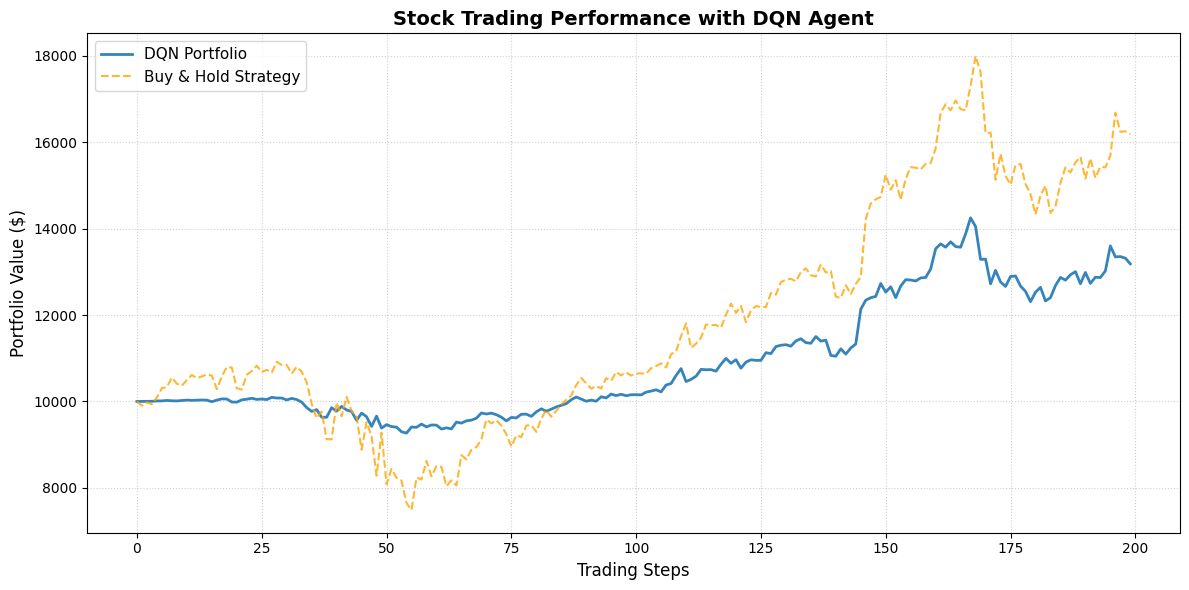

In [20]:
# %% Fetching data:
def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %% Adding indicators:
def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['rolling_std'] = df['Close'].rolling(window=window_sma).std()
    df['BB_upper'] = df['SMA'] + (2 * df['rolling_std'])
    df['BB_lower'] = df['SMA'] - (2 * df['rolling_std'])
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Stochastic %K
    low_min = df['Low'].rolling(window=14).min()
    high_max = df['High'].rolling(window=14).max()
    df['Stochastic_K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))

    df.drop(columns=['rolling_std'], inplace=True)
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    return df

# %% Custom Gym Trading Environment
class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, df, initial_balance=10000, max_steps=200):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.action_space = spaces.Discrete(3)
        obs_low = np.array([0]*11 + [0, 0], dtype=np.float32)
        obs_high = np.array([np.inf]*10 + [100, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(),
            row['SMA'].item(),
            row['EMA'].item(),
            row['RSI'].item(),
            row['MACD'].item(),
            row['MACD_signal'].item(),
            row['BB_upper'].item(),
            row['BB_lower'].item(),
            row['Open'].item(),
            row['Volume'].item(),
            row['Stochastic_K'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1:  # buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
        elif action == 2:  # sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()
        reward = self.net_worth - prev_net_worth

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")

# %% Neural Network Model
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %% Experience Replay Buffer
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# %% Hyperparameters
episode_count = 500
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# %% Fetch and prepare training data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)
env = TradingEnv(df, initial_balance=10000, max_steps=200)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0


# %% Action selection function
def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return policy_net(state_v).argmax().item()

# %% Training loop
for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")



# Re-run environment to track agent performance
state = env.reset()
portfolio_values = []
s = state
for _ in range(env.max_steps):
    state_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
    action = policy_net(state_tensor).argmax().item()
    s, _, done, _ = env.step(action)
    portfolio_values.append(env.net_worth)
    if done:
        break

# Buy-and-Hold (baseline) for aligned steps
close_prices = df['Close'].iloc[:len(portfolio_values)].values
buy_hold_values = (close_prices / close_prices[0]) * env.initial_balance

# Adding more technical indicators visually
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='DQN Portfolio', linewidth=2, alpha=0.9)
plt.plot(buy_hold_values, label='Buy & Hold Strategy', linestyle='--', color='orange', alpha=0.8)

plt.title("Stock Trading Performance with DQN Agent", fontsize=14, weight='bold')
plt.xlabel("Trading Steps", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=11)
plt.tight_layout()
plt.show()



<font size = 5>**Evaluation on unseen test data**

/tmp/ipython-input-20-2951419495.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-20-2951419495.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=['rolling_std'], inplace=True)


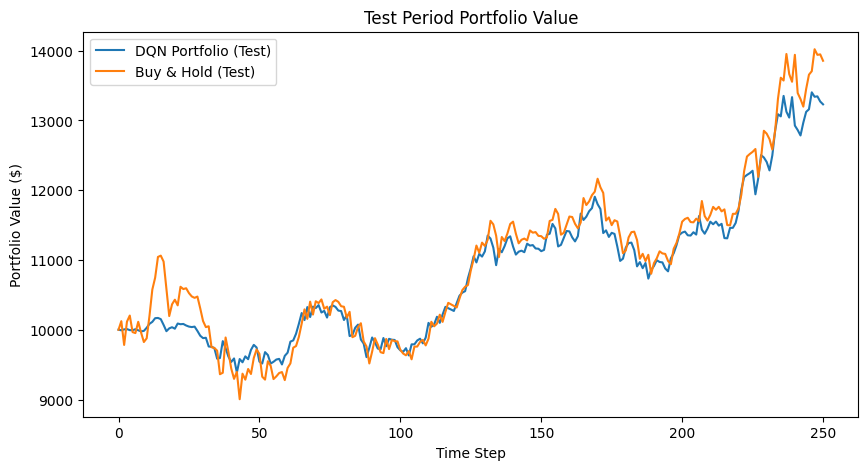

In [21]:
# %% Evaluation on unseen test data
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01')
df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1)

state = env_test.reset()
values_test = []
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    state, _, done, _ = env_test.step(action)
    values_test.append(env_test.net_worth)
    if done:
        break

bh_test = df_test['Close'].iloc[:len(values_test)].values
bh_values_test = bh_test / bh_test[0] * env_test.initial_balance

plt.figure(figsize=(10, 5))
plt.plot(values_test, label='DQN Portfolio (Test)')
plt.plot(bh_values_test, label='Buy & Hold (Test)')
plt.title("Test Period Portfolio Value")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()